In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
import pylab
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# for ANN   

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
#讀取資料並列出前五筆
df=pd.read_csv("C:/Users/User/Desktop/(Practice) Kaggle/(Practice) Bank Customer Churn Prediction/Churn_Modelling.csv")
print(df.head())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

In [5]:
#把不具有意義、可能會模型成效的欄刪除
df.drop(columns=['RowNumber','CustomerId','Surname'],inplace=True)

In [6]:
#查看df中各欄位的資料筆數、是否有缺失值、Data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [7]:
#敘述性統計
df.describe().T #探討coefficient of variation(cv)

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


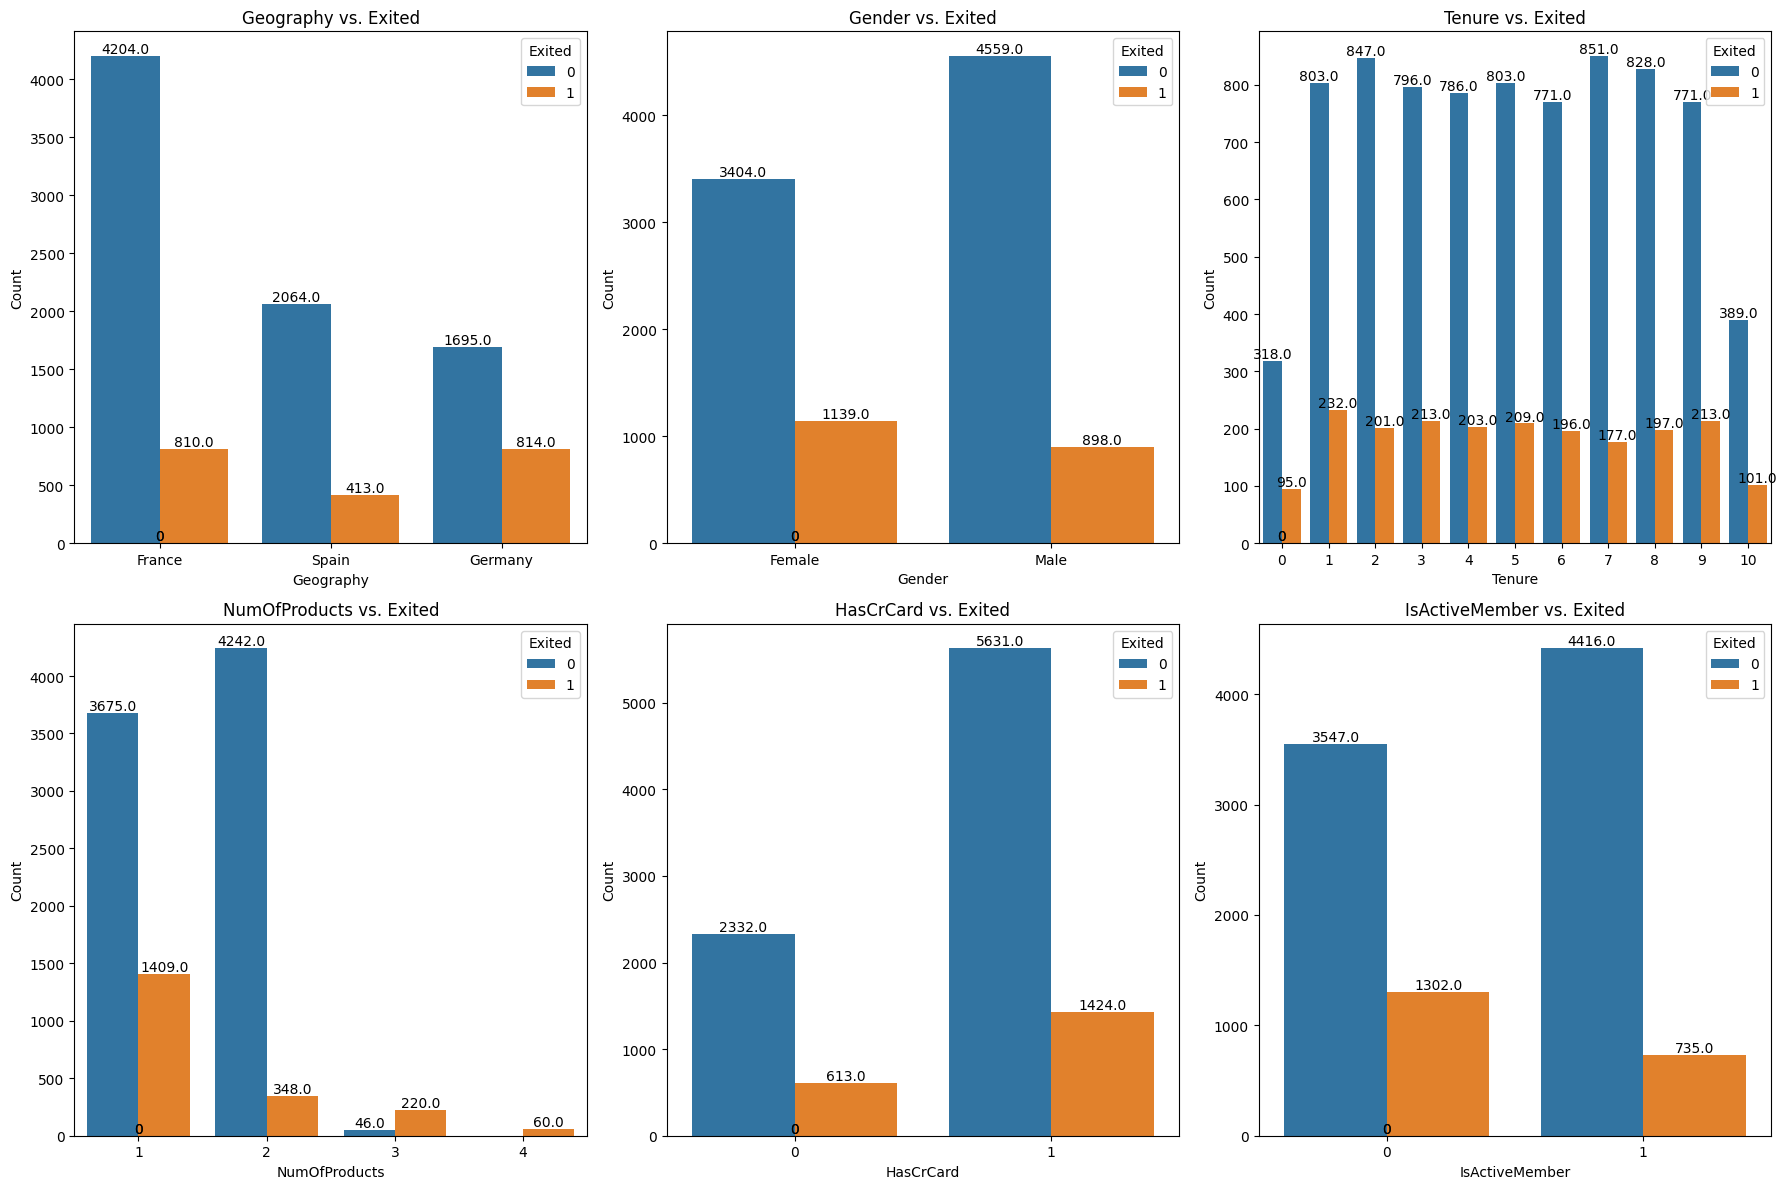

In [8]:
#長條圖：無連續的變數(類別，catrgorical variables)
features = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

for ax, feature in zip(axs.flatten(), features):
    sns.countplot(x=feature, hue='Exited', data=df, ax=ax)
    ax.set_title(f'{feature} vs. Exited')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')

    #在bar上加入數值
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.show()

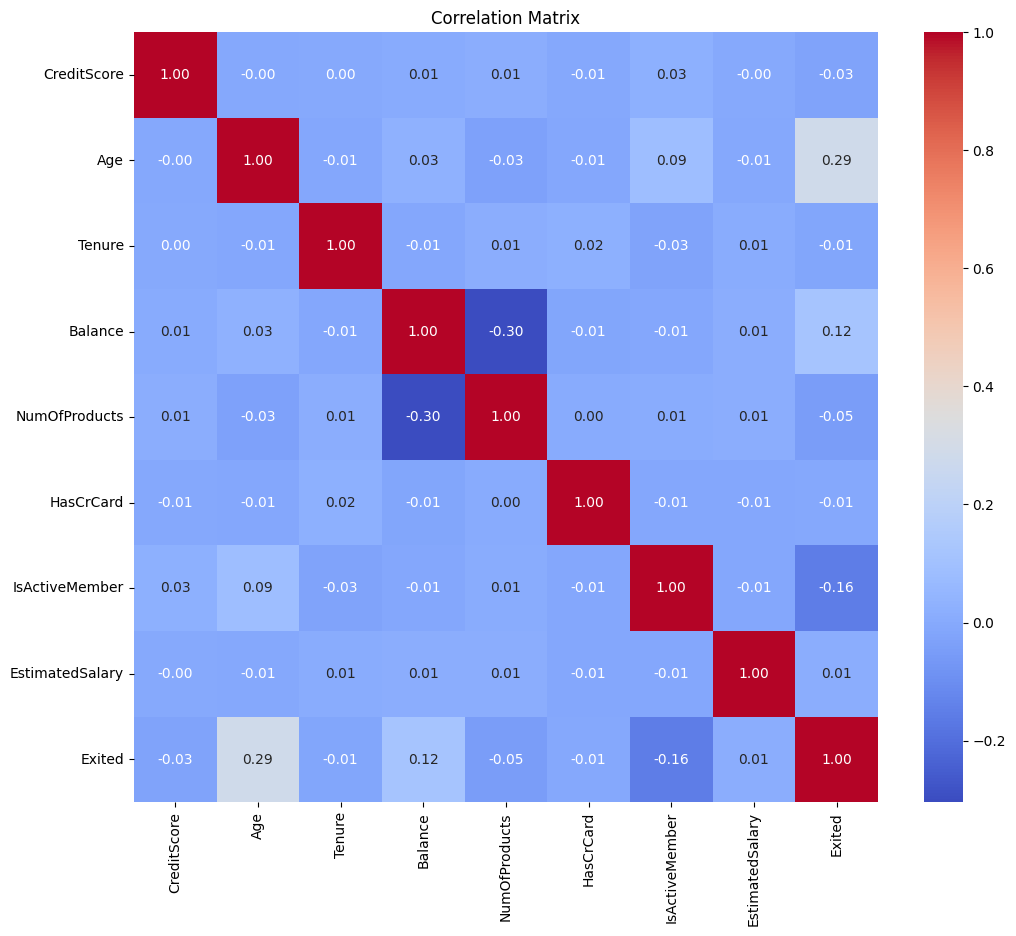

In [9]:
# 相關矩陣，顏色越深(越接近1)，代表越正相關
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

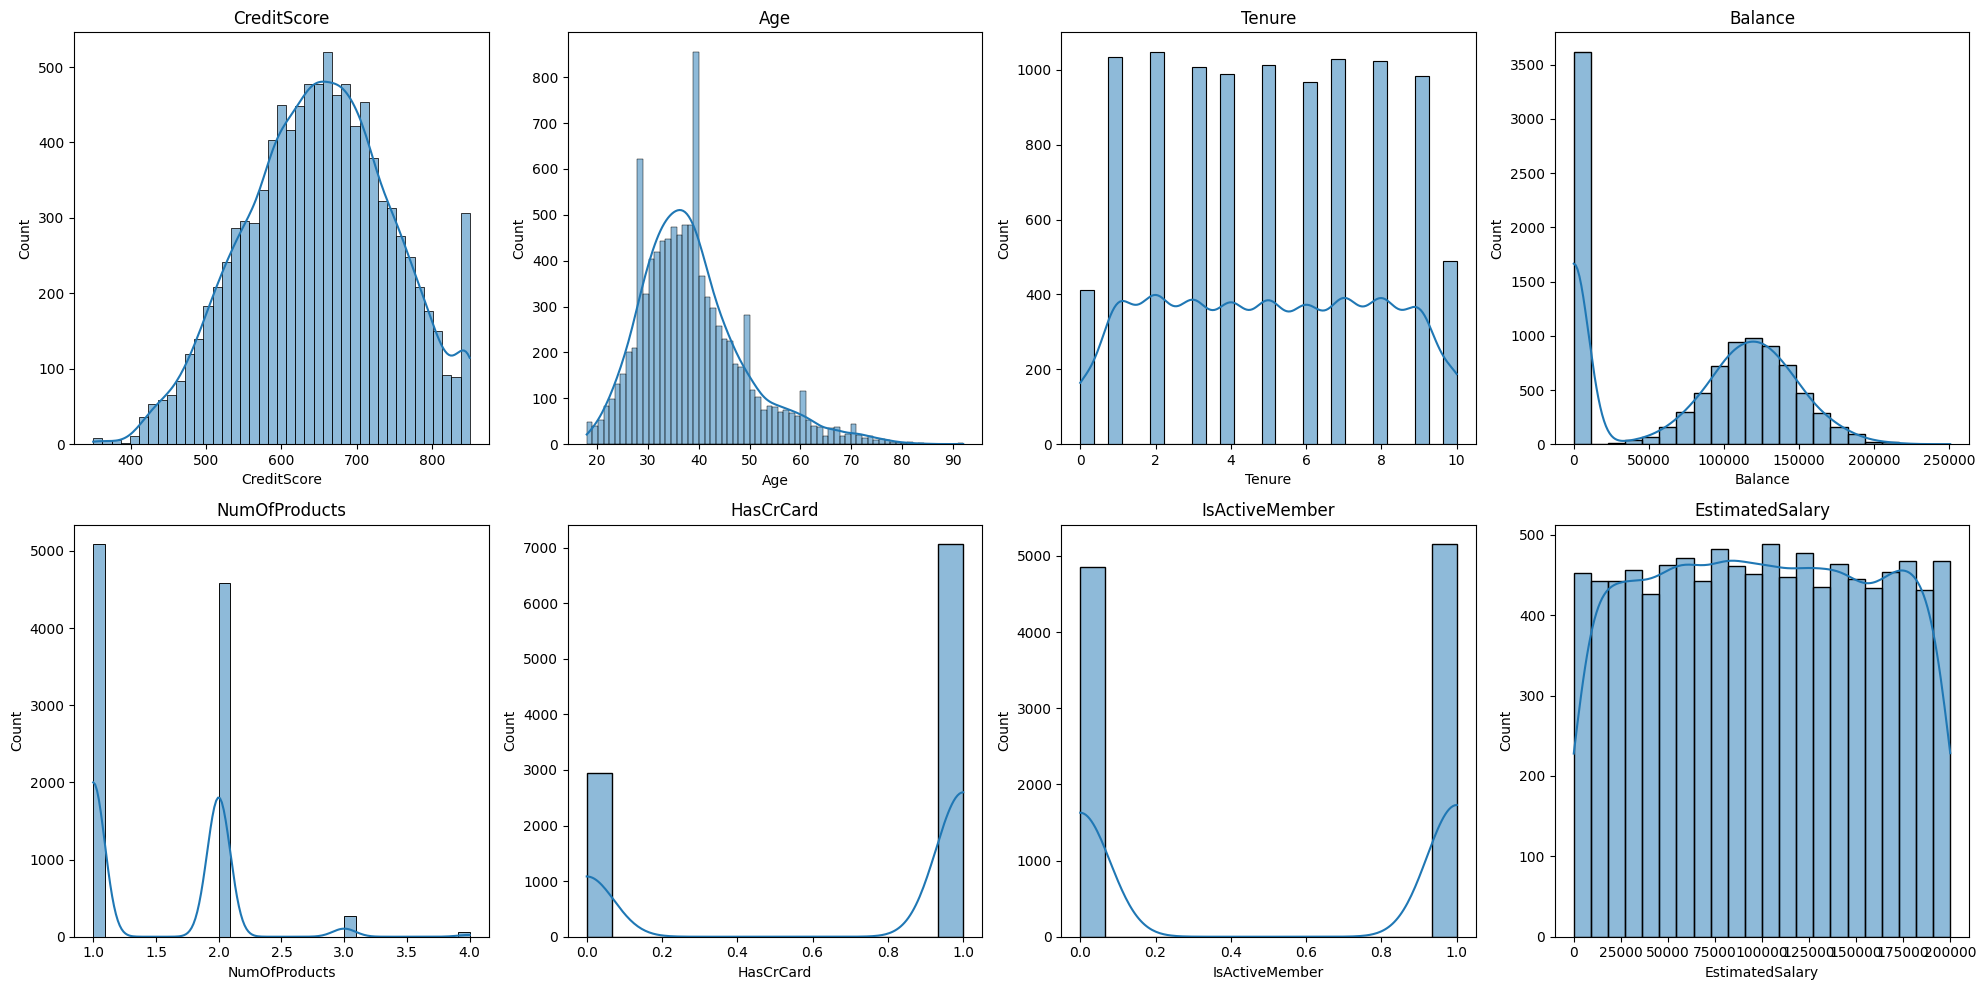

In [10]:
# 直方圖(連續型變數，continuous)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# 將這些連續型變數建立list
variables = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

for ax, var in zip(axes.flatten(), variables):
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_title(var)

plt.tight_layout()
plt.show()

In [11]:
# 偏態：查看資料分布的尾巴偏向哪一邊(使用dtype為數值的，才能計算)，越接近0代表越常態 -> 偏態嚴重可能會影響模型成效
print(df.select_dtypes(include=['number']).skew())
print("Skewness before transformation:")
print(df['Age'].skew()) #因為age的偏態已大於1，我們欲將偏態的資料印出轉換前的數值，方可比較

# 使用對數轉換(Logarithmic Transformation，適用於正偏態數據)於age，能夠縮減偏態(壓縮尾巴資料)，使分布更接近常態
# 加上一個非常小的常數 (1e-9) 避免log(0)的情況
df['Age'] = np.log10(df['Age'] + 1e-9)

print("Skewness after transformation:")
print(df['Age'].skew())

CreditScore       -0.071607
Age                1.011320
Tenure             0.010991
Balance           -0.141109
NumOfProducts      0.745568
HasCrCard         -0.901812
IsActiveMember    -0.060437
EstimatedSalary    0.002085
Exited             1.471611
dtype: float64
Skewness before transformation:
1.0113202630234552
Skewness after transformation:
0.18202011258158898


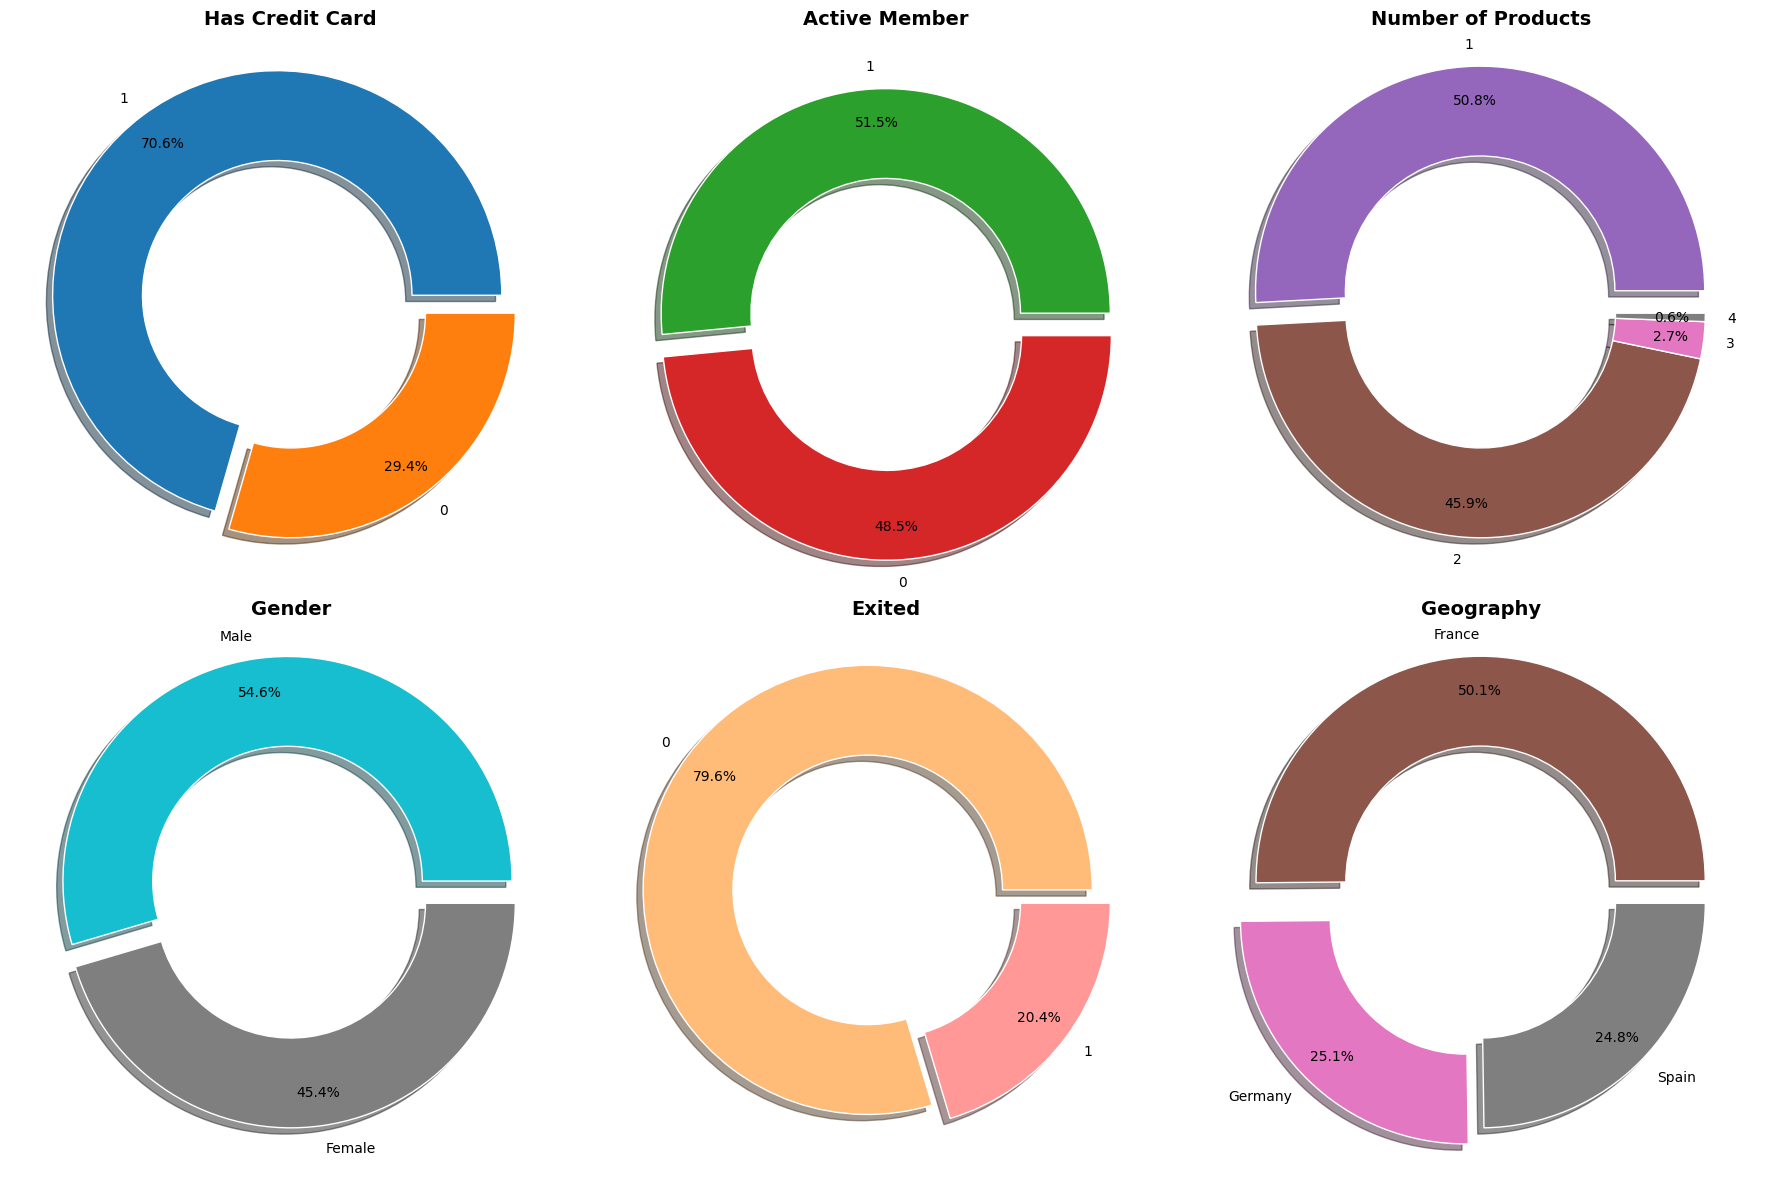

In [12]:
# 定義各個圓餅圖的顏色
colors = {
    'HasCrCard': ['#1f77b4', '#ff7f0e'],
    'IsActiveMember': ['#2ca02c', '#d62728'],
    'NumOfProducts': ['#9467bd', '#8c564b', '#e377c2', '#7f7f7f'],
    'Gender': ['#17becf', '#7f7f7f'],
    'Exited': ['#ffbb78', '#ff9896'],
    'Geography': ['#8c564b', '#e377c2', '#7f7f7f']
}
#強調特定區塊
explode_values = {
    'HasCrCard': (0.1, 0),
    'IsActiveMember': (0, 0.1),
    'NumOfProducts': (0.1, 0, 0, 0),
    'Gender': (0.1, 0),
    'Exited': (0.1, 0),
    'Geography': (0.1, 0.1, 0)
}

# 規劃排序為兩列三行的形式(子圖)
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# 每個子圖的名稱
columns = ['HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Gender', 'Exited', 'Geography']
titles = ['Has Credit Card', 'Active Member', 'Number of Products', 'Gender', 'Exited', 'Geography']

# 繪製每個子圖
for ax, column, title in zip(axs.flatten(), columns, titles):
    counts = df[column].value_counts()
    ax.pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        colors=colors[column],
        explode=explode_values[column] + (0,) * (len(counts) - len(explode_values[column])),
        shadow=True,
        wedgeprops=dict(width=0.4, edgecolor='w'),
        pctdistance=0.85
    )
    ax.set_title(title, fontsize=14, fontweight='bold')

# 調整子徒之間的艱鉅，避免標題、數據重疊，並印出圖表
plt.tight_layout()
plt.show()

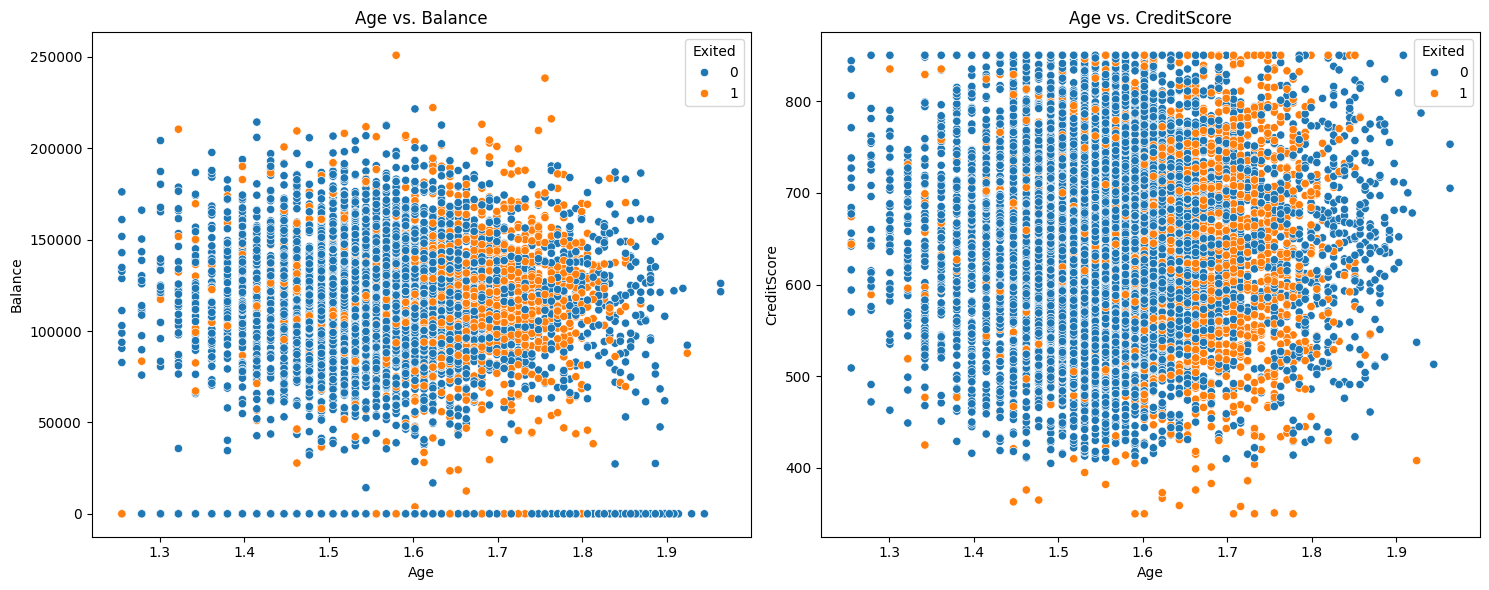

In [13]:
#欲比較Age與Balance & Age與CreditScore之間的關係
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(x='Age', y='Balance', hue='Exited', data=df, ax=axs[0])
sns.scatterplot(x='Age', y='CreditScore', hue='Exited', data=df, ax=axs[1])

axs[0].set_title('Age vs. Balance')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Balance')
axs[1].set_title('Age vs. CreditScore')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('CreditScore')

plt.tight_layout()
plt.show()

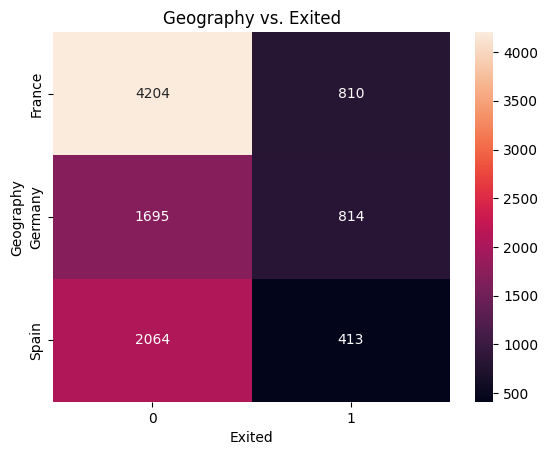

In [14]:
# 繪製交叉表(crosstab)和heatmap來呈現不同國籍與客戶流失之間的關係
table = pd.crosstab(df['Geography'], df['Exited'])
sns.heatmap(table, annot=True,  fmt='g')
plt.title('Geography vs. Exited')
plt.show()

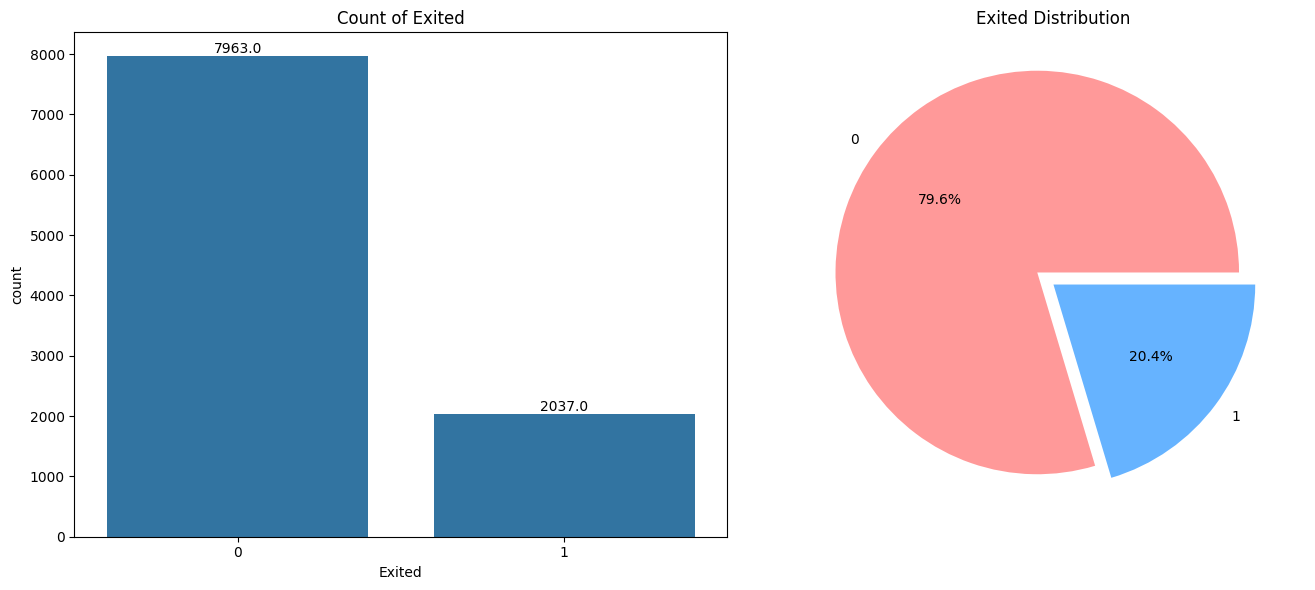

In [15]:
#用長條圖和圓餅圖來查看客戶流失的分布情形 -> 發現有資料不平衡的問題(class embalance)
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# 長條圖
sns.countplot(x='Exited', data=df, ax=axs[0])
axs[0].set_title('Count of Exited')
for p in axs[0].patches:
    height = p.get_height()
    axs[0].annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# 圓餅圖
exit_counts = df['Exited'].value_counts()
axs[1].pie(exit_counts, labels=exit_counts.index, autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'], explode=(0.1, 0))
axs[1].set_title('Exited Distribution')
plt.tight_layout()
plt.show()

In [16]:
#因為種類不平衡，使用Upsampling來解決(將類別數量較少的增加到與類別數量多的相同)
df_majority = df[df['Exited'] == 0]
df_minority = df[df['Exited'] == 1]

# Upsampling
df_minority_upsampled = resample(df_minority,
                                 replace=True,  # 允許重複抽樣
                                 n_samples=len(df_majority),  #使樣本數等於多數類別
                                 random_state=42)  # 隨機種子

# 合併兩類別(7963 + 7963)
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# shuffle，確保偷看的情形不會發生
df= df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

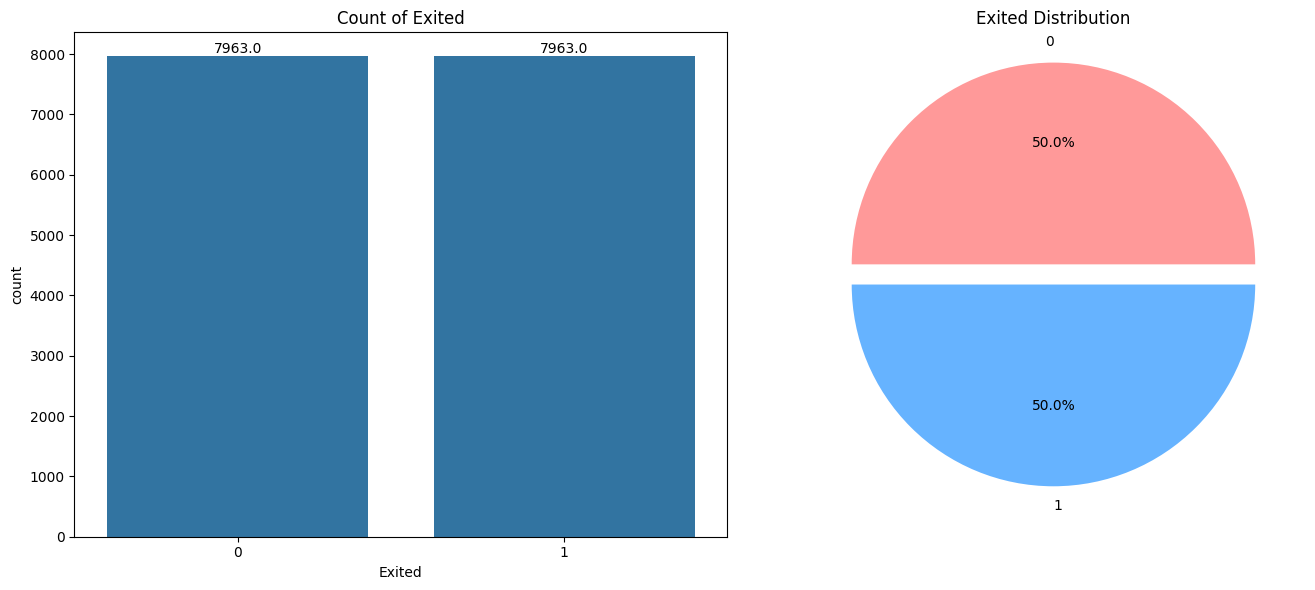

In [17]:
#將Upsampling完的結果視覺化並察看結果是否與我們操作的相符
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# 長條圖
sns.countplot(x='Exited', data=df, ax=axs[0])
axs[0].set_title('Count of Exited')
for p in axs[0].patches:
    height = p.get_height()
    axs[0].annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# 圓餅圖
exit_counts = df['Exited'].value_counts()
axs[1].pie(exit_counts, labels=exit_counts.index, autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'], explode=(0.1, 0))
axs[1].set_title('Exited Distribution')

plt.tight_layout()
plt.show()

In [18]:
# 將Geography, Gender使用one-hot encoding
df = pd.get_dummies(df, columns=['Geography','Gender'], drop_first=True)

In [19]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,692,1.662758,2,0.00,2,1,1,105983.09,0,False,True,True
1,516,1.568202,8,113143.12,1,0,0,3363.36,0,False,False,False
2,531,1.568202,1,143407.29,2,0,1,84402.46,0,False,True,True
3,717,1.556303,2,99472.76,2,1,0,94274.72,1,False,False,False
4,737,1.633468,1,125537.38,1,1,0,138510.01,1,True,False,False


In [20]:
# 切割訓練集 & 測試集
X = df.drop(columns=['Exited'])
y = df['Exited']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [21]:
from sklearn.preprocessing import StandardScaler
# 將資料進行標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# 建立模型(Sequential)，初始化模型
model = Sequential()
    
#輸入層與第一個隱藏層
#Dense()：全連接層，units=352：這層含有352個神經元，激活函數使用Tanh，Feature共有11個
model.add(Dense(units=352, activation='tanh', input_dim = 11))
model.add(Dropout(0.2)) #避免Overfitting，使用dropout

# 此模型包含多個隱藏層，每層使用不同的神經元、激活函數和dropout
model.add(Dense(units=160, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.01))
model.add(Dense(units=384, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.01))
model.add(Dense(units=448, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(units=352, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.34))
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.0))
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.0))
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.0))

    # Output layer
model.add(Dense(units=1, activation='sigmoid'))  # Change to 'softmax' for multi-class classification

c:\Users\User\anaconda3\envs\test\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 352)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 160)            │        56,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160)            │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 384)            │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 448)            │       172,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 448)            │         1,792 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 352)            │       158,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 352)            │         1,408 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │        11,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32)             │           12

 Total params: 472,257 (1.80 MB)

 Trainable params: 469,377 (1.79 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [ ]:
# 編譯模型
model.compile(optimizer=Adam(learning_rate=0.001), #使用Adam的optimizer
                  loss='binary_crossentropy',  # 二元分類問題使用Binary Crossentropy
                  metrics=['accuracy']) #以準確率為評估指標

In [ ]:
# 定義早停法該在甚麼情況下停止
early_stopping = EarlyStopping( patience=5, restore_best_weights=True)
# 開始訓練模型
history = model.fit(X_train, y_train,epochs=500,
validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/500
399/399 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6964 - loss: 0.5924 - val_accuracy: 0.7558 - val_loss: 0.5053
Epoch 2/500
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7417 - loss: 0.5230 - val_accuracy: 0.7646 - val_loss: 0.4719
Epoch 3/500
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7597 - loss: 0.4903 - val_accuracy: 0.7718 - val_loss: 0.4689
Epoch 4/500
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7689 - loss: 0.4825 - val_accuracy: 0.7768 - val_loss: 0.4623
Epoch 5/500
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7740 - loss: 0.4701 - val_accuracy: 0.7728 - val_loss: 0.4649
Epoch 6/500
399/399 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7729 - loss: 0.4752 - val_accuracy: 0.7765 - val_loss: 0.4587
Epoch 7/500
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7699 - loss: 0.4721 - val_accuracy: 0.7775 - val_loss: 0.4577
Epoch 8/500
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7741 - loss: 0.4647 - val_accu

In [ ]:
# 評估模型成效
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8785 - loss: 0.2931
Test accuracy: 0.8810420632362366


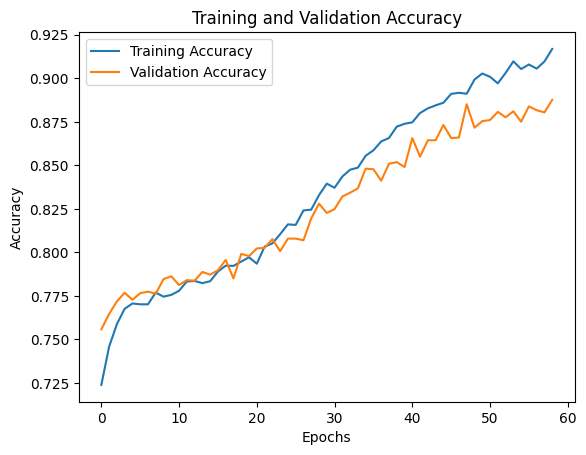

In [ ]:
# 繪製訓練集的正確率
plt.plot(history.history['accuracy'], label='Training Accuracy')
# 繪製驗證集的正確率
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# 加上x, y軸的象限名稱
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
# 增加圖例
plt.legend()

plt.show()

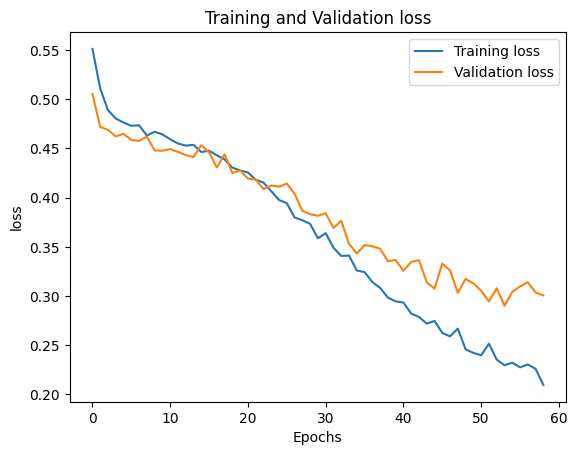

In [ ]:
# 繪製訓練集的loss
plt.plot(history.history['loss'], label='Training loss')
# 繪製驗證集的loss
plt.plot(history.history['val_loss'], label='Validation loss')

# 加上x, y兩象限的名稱
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Training and Validation loss')
# 加上圖例
plt.legend()

plt.show()

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      1582
           1       0.83      0.96      0.89      1604

    accuracy                           0.88      3186
   macro avg       0.89      0.88      0.88      3186
weighted avg       0.89      0.88      0.88      3186



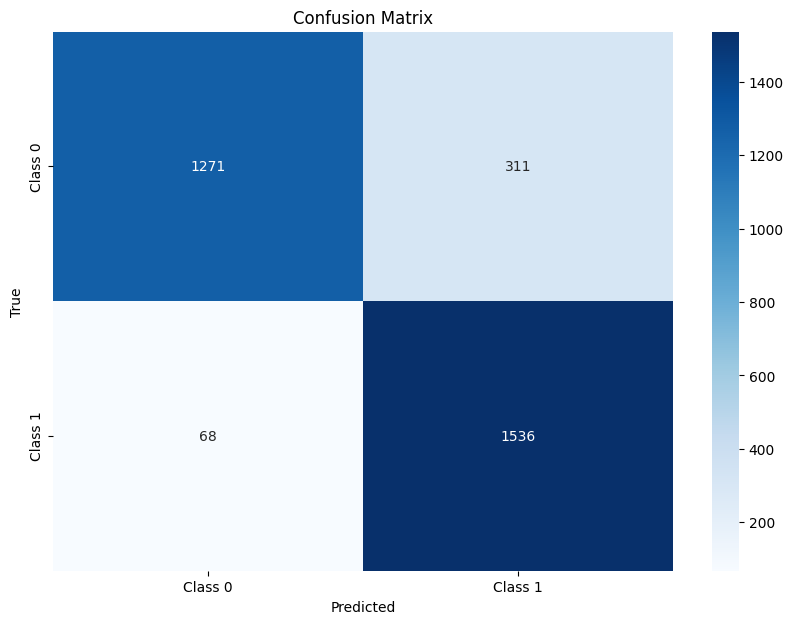

In [ ]:
#預測出測試集的結果
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # 將output的機率轉為二元的結果

# 印出分類結果
print(classification_report(y_test, y_pred))

# 計算混淆矩陣
cm = confusion_matrix(y_test, y_pred)

# 繪製混淆矩陣
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()